# Using Machine Learning to Predict the Weather: Part 2

This article is a continuation of the prior article in a three part series on using Machine Learning in Python to predict weather temperatures for the city of Lincoln, Nebraska in the United States based off data collected from Weather Underground's API services.  In the first article of the series, **[Using Machine Learning to Predict the Weather: Part 1](http://stackabuse.com/using-machine-learning-to-predict-the-weather-part-1/)**, I described how to extract the data from Weather Underground, parse and, clean it.  For a summary of the topics for each of the articles presented in this series please see the introduction to the prior article.

The focus of this aricle will be to describe the processes and steps required to build a rigorous Linear Regression model to predict future mean daily temperature values based off the dataset built in the prior article.  To build the Linear Regression model I will be demonstrating the use of two important Python libraries in the Machine Learning industry; [Scikit-Learn](http://scikit-learn.org/) and [StatsModels](http://www.statsmodels.org/).

### Refamiliarizing Ourselves with the Dataset

In this [ghttp://localhost:8890/notebooks/Weather%20Underground%20Linear%20Regression.ipynb#ithub repository]() you will find a Jupyter Notebook with the file name *Weather Underground API.ipynb* which describes the step-by-step actions required to collect the dataset we will be working with in this and the upcoming article.  Additionally, in this repository you will find a pickled Pandas DataFrame file called *end-part1_df.pkl*.  So, if you would like to follow along without going through the somewhat painful experience of gather, processing, and cleaning the data described in the prior article then pull down the pickle file and use the following code to deserialize the data back into a Pandas DataFrame for use in this section.

If you recieve an error stating *No module named 'pandas.indexes'* this is because you are probably using a version of pandas newer than the one I was using at the time of writing this article (v 0.18.1).  I have since then included a csv file containing the data from the end of part 1 that you can read in using the following code instead.

In [15]:
import pickle
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject/Train/Taipei/Taipei_X.csv').set_index('Unnamed: 0')
df_y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject/Train/Taipei/Taipei_y.csv').set_index('Unnamed: 0')
print(df)
print(df_y)

            觀測時間(day)  測站氣壓(hPa)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)
Unnamed: 0                                                 
0                   1     1010.7     22.3     19.8       93
1                   2     1010.4     24.2     20.2       90
2                   3     1010.9     25.6     21.5       89
3                   4     1015.3     23.5     19.4       86
4                   5     1017.9     21.5     18.9       82
...               ...        ...      ...      ...      ...
755                27     1014.7     19.7     17.2       82
756                28     1018.5     18.2     13.6       80
757                29     1021.6     16.6     14.5       56
758                30     1019.6     22.2     14.6       61
759                31     1018.1     24.3     14.3       64

[760 rows x 5 columns]
            氣溫(℃)
Unnamed: 0       
0            20.9
1            21.9
2            23.4
3            21.4
4            19.9
...           ...
755          18.2
756          16.1
757          15.

### Theoretical Background on Linear Regression using Ordinary Least Squares

In selecting features to include in this linear regression model I would like to error on the side of being slightly less permissive in including variables with moderate or lower correlation coefficients. So I will be removing the features that have correlation values less than the absolute value of 0.6. Also, since the mintempm and maxtempm variables are for the same day as the prediction variable meantempm I will be removing those also (ie, if I already know the min and max temperatures then I already have the answer to my prediction).

With this information, I can now create a new DataFrame that only contains my variables of interest.

In [22]:
df.columns = ['Day','Pressure','Max Temperature','Min Temperature','Relative Humidity']
predictors = ['Pressure','Max Temperature','Min Temperature','Relative Humidity']
df2 = df[predictors]

### Getting a Visual of the Relationships

Because most people, myself included, are much more accustomed to looking at visuals to assess and verify patterns I will be graphing each of these selected predictors to prove to myself that there is in fact a linear relationship. To do this I will utilize matplotlib's pyplot module.

For this plot I would like to have the dependent variable meantempm be the consistent y axis along all of the 18 predictor variables plots.  One way to accomplish this is to create a grid of plots.  Pandas does come with a useful plotting function called the `scatter_plot()` but, I generally only use it when there are only up to about 5 variables because it turns the plot into an N x N matrix (18 x 18 in our case) which becomes difficult to see details in the data. Instead I will create a grid structure with six rows of three columns to avoid sacrificing clarity in the graphs.

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

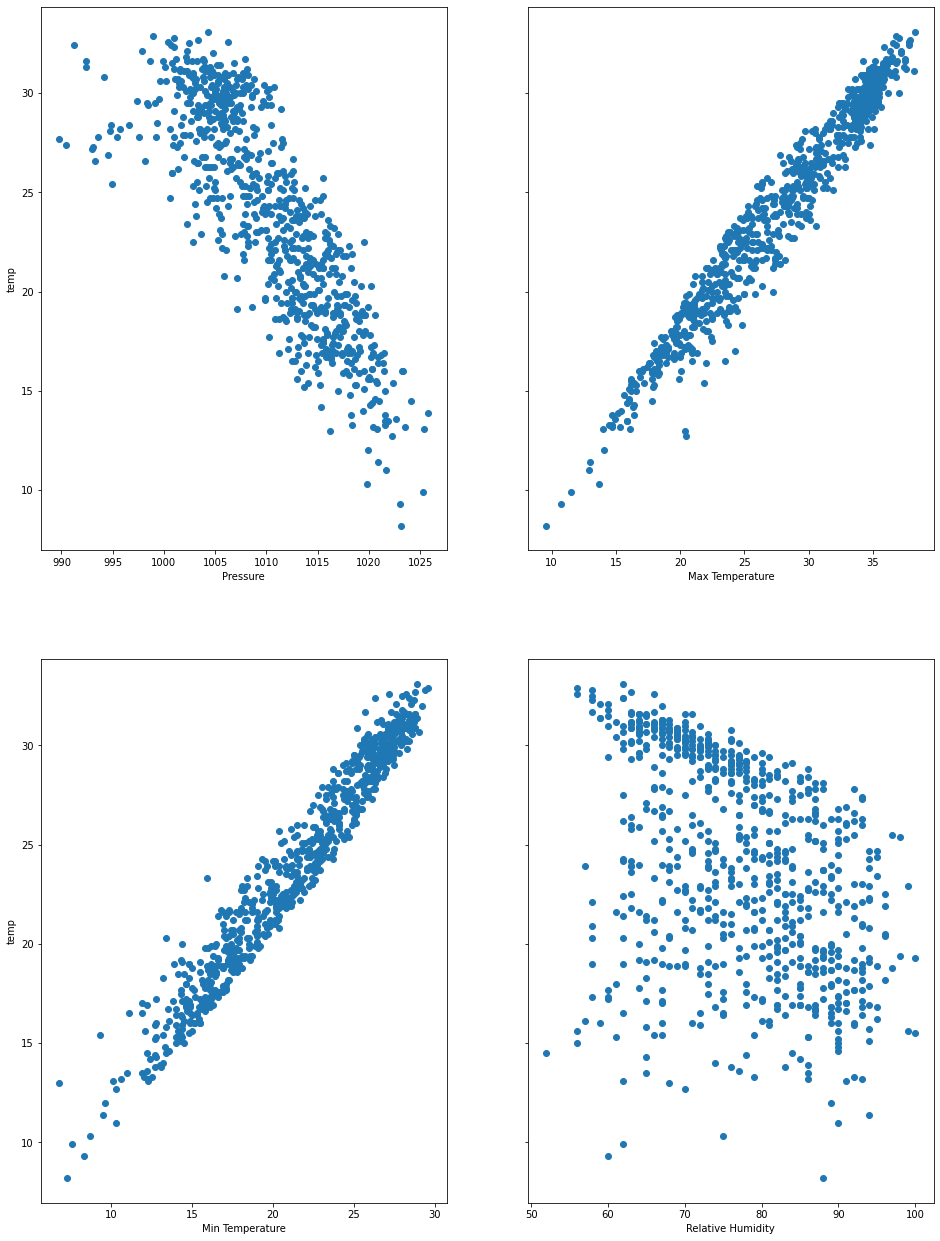

In [24]:
%matplotlib inline


# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(2, 2)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df_y)
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='temp')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

From the plots above it is recognizable that all the remaining predictor variables show a good linear relationship with the response variable (meantempm).  Additionally, it is also worth noting that the relationships all look uniformly randomly distributed.  By this I mean there appears to be relatively equal variation in the spread of values devoid of any fanning or cone shape.  A uniform random distribution of spread along the points is also another important assumption of Linear Regression using Ordinary Least Squares algorithm.

### Using Step-wise Regression to Build a Robust Model

A robust Linear Regression model should utilize statistical tests for selecting meaningful, statistically significant, predictors to include. To select statistically significant features, I will utilize the Python statsmodels library. However, before I jump into the practical implementation of using the statsmodels library I would like to take a step back and explain some of the theoretical meaning and purpose for taking this approach.
A key aspect of using statistical methods such as Linear Regression in an analytics project are the establishment and testing of hypothesis tests to validate the significance of assumptions made about the data under study. There are numerous hypothesis tests that have been developed to test the robustness of a linear regression model against various assumptions that are made. One such hypothesis test is to evaluate the significance of each of the included predictor variables.

The formal definition of the hypothesis test for the significance of a $\beta_j$ parameters are as follows:

  * $H_0$: $\beta_j$ = 0, the null hypothesis states that the predictor has no effect on the outcome variable's value
  * $H_a$: $\beta_j \neq$ 0, the alternative hypothesis is that the predictor has a significant effect on the outcome variable's value
  
By using tests of probability to evaluate the likelihood that each $\beta_j$ is significant beyond simple random chance at a selected threshold $\alpha$ we can be more stringent in selecting the variables to include resulting in a more robust model.

However, in many datasets there can be interactions that occur between variables that can lead to false interpretations of these simple hypothesis tests. To test for the effects of interactions on the significance of any one variable in a linear regression model a technique known as step-wise regression is often applied. Using step-wise regression you add or remove variables from the model and assess the statistical significance of each variable on the resultant model.

In this article, I will be using a technique known as backward elimination where I begin with a fully loaded general model that includes all my variables of interest.

Backward Elimination works as follows:
1. Select a significance level $\alpha$ for which you test your hypothesis against to determine if a variable should stay in the model
2. Fit the model with all predictor variables
3. Evaluate the p-values of the $\beta_j$ coefficients and for the one with the greatest p-value, if p-value > $\alpha$ progress to step 4, if not you have your final model
4. Remove the predictor identified in step 3
5. Fit the model again but, this time without the removed variable and cycle back to step 3

So, without further delay let us build this fully loaded generalized model using statsmodels following the above steps.

In [25]:
# import the relevant module
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors]
y = df_y

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X.iloc[:5, :5]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,Pressure,Max Temperature,Min Temperature,Relative Humidity
Unnamed: 0,,,,,
0,1.0,1010.7,22.3,19.8,93
1,1.0,1010.4,24.2,20.2,90
2,1.0,1010.9,25.6,21.5,89
3,1.0,1015.3,23.5,19.4,86
4,1.0,1017.9,21.5,18.9,82


In [26]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  氣溫(℃)   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.771e+04
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:13:28   Log-Likelihood:                -445.93
No. Observations:                 760   AIC:                             901.9
Df Residuals:                     755   BIC:                             925.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.5126      5.046      5.453      0.000      17.607      37.418
Pressure             -0.0250      0.005     -5.194      0.000      -0.034      -0.016
Max Temperature       0.3984      0.008     49.411      0.000       0.383       0.414
Min Temperature       0.5496      0.009     62.560      0.000       0.532       0.567
Relative Humidity    -0.0135      0.002     -6.681      0.000      -0.017      -0.010
==============================================================================
Omnibus:                       27.919   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.501
Skew:                          -0.267   Prob(JB):                     2.94e-11
Kurtosis:                       4.116   Cond. No.                     3.23e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ok, I recognize that the call to `summary()` just barfed out a whole lot of information onto the screen. Do not get overwhelmed! We are only going to focus on about 2-3 values in this article:

1.	P>|t| - this is the p-value I mentioned above that I will be using to evaluate the hypothesis test. This is the value we are going to use to determine whether to eliminate a variable in this step-wise backward elimination technique.
2.	R-squared - a measure that states how much of the overall variance in the outcome our model can explain
3.	Adj. R-squared - the same as R-squared but, for multiple linear regression this value has a penalty applied to it based off the number of variables being included to explain the level of overfitting.

This is not to say that the other values in this output are without merit, quite the contrary. However, they touch on the more esoteric idiosyncrasies of linear regression which we simply just don't have the time to get into now. For a full explanation of them I will defer you to an advanced regression textbook such as Kutner's **Applied Linear Regression Models, 4th Ed.** as well as the statsmodels documentation.

In respect of your reading time and in an attempt to keep the article to a reasonable length I am going to omit the remaining elimination cycles required to build each new model, evaluate p-values and remove the least significant value.  Instead I will jump right to the last cycle and provide you with the final model.  Afterall, the main goal here was to describe the process and the reasoning behind it.

Below you will find the output from the final model I converged on after applying the backwards elimination technique.  You can see from the output that all the remaining predictors have a p-values significantly below our $\alpha$ of 0.05.  Another thing worthy of some attention are the R-squared values in the final output. Two things to note here are (1) the R-squared and Adj. R-squared values are both equal which suggests there is minimal risk that our model is being over fitted by excessive variables and (2) the value of 0.894 is interpreted such that our final model explains about 90% of the observed variation in the outcome variable, the meantempm.

In [ ]:
X = X[['const','mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1', 'maxdewptm_3', 'mindewptm_1', 'maxtempm_1']]

In [ ]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              meantempm   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     1196.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        08:52:26   Log-Likelihood:                -2681.7
No. Observations:                 997   AIC:                             5379.
Df Residuals:                     989   BIC:                             5419.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1534      0.411      2.804      0.005       0.346       1.961
mintempm_1      0.1310      0.053      2.458      0.014       0.026       0.236
mintempm_2     -0.0964      0.037     -2.620      0.009      -0.169      -0.024
mintempm_3      0.0886      0.041      2.183      0.029       0.009       0.168
maxdewptm_1    -0.1939      0.047     -4.117      0.000      -0.286      -0.101
maxdewptm_3     0.1269      0.040      3.191      0.001       0.049       0.205
mindewptm_1     0.3352      0.051      6.605      0.000       0.236       0.435
maxtempm_1      0.5506      0.024     22.507      0.000       0.503       0.599
==============================================================================
Omnibus:                       13.123   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.871
Skew:                          -0.163   Prob(JB):                     0.000217
Kurtosis:                       3.548   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
#X = X.drop('const', axis=1)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

            mintempm_1  mintempm_2  mintempm_3  maxdewptm_1  maxdewptm_3  \
date                                                                       
2015-01-04       -13.0       -12.0       -13.0         -4.0         -6.0   
2015-01-05       -18.0       -13.0       -12.0        -16.0         -6.0   
2015-01-06       -14.0       -18.0       -13.0         -8.0         -4.0   
2015-01-07       -14.0       -14.0       -18.0        -12.0        -16.0   
2015-01-08       -19.0       -14.0       -14.0        -18.0         -8.0   
...                ...         ...         ...          ...          ...   
2017-09-23        24.0        15.0        16.0         22.0         22.0   
2017-09-24        21.0        24.0        15.0         19.0         23.0   
2017-09-25        17.0        21.0        24.0         19.0         22.0   
2017-09-26        14.0        17.0        21.0         17.0         19.0   
2017-09-27        11.0        14.0        17.0         13.0         19.0   

           

The next action to take is to build the regression model using the training dataset. To this I will import and use the `LinearRegression` class from the `sklearn.linear_model` module.  As mentioned previously, scikit-learn scores major usability bonus points by implementing a common `fit()` and `predict()` API across its numerous numerical techniques which makes using the library very user friendly.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degress celcius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celcius" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.90
The Mean Absolute Error: 2.69 degress celcius
The Median Absolute Error: 2.17 degrees celcius


As you can see in the few lines of code above using scikit-learn to build a Linear Regression prediction model is quite simple.  This is truly where the library shines in its ability to easily fit a model and make predictions about an outcome of interest.  

To gain an interpretative understanding of the models validity I used the regressor model's `score()` function to determine that the model is able to explain about 90% of the variance observed in the outcome variable, mean temperature.  Additionally, I used the `mean_absolute_error()` and `median_absolute_error()` of the `sklearn.metrics` module to determine that on average the predicted value is about 3 degrees Celsius off and half of the time it is off by about 2 degrees Celsius.

### Conclusion

In this article, I demonstrated how to use the Linear Regression Machine Learning algorithm to predict future mean weather temperatures based off the data collected in the prior article. I demonstrated how to use the statsmodels library to select statistically significant predictors based off sound statistical methods. I then utilized this information to fit a prediction model based off a training subset using Scikit-Learn's LinearRegression class. Using this fitted model I could predict the expected values of based off the inputs from a testing subset and evaluate the accuracy of the prediction which indicates a reasonable amount of accuracy.

I would like to thank you for reading my article and I hope you look forward to the upcoming final article in this machine learning series where I describe how to build a Neural Network to predict the weather temperature.